# Exploratory and Statistical Data Analysis for Iced company

The objective of this project is to identify patterns that determine whether a game is successful or not for sale. This will allow us to detect promising projects and plan advertising campaigns for the following year (2017).

To achieve the objective, the data received will be prepared, then analyzed in order to create a user profile for each of the relevant regions (North America, the European Union and Japan). Additionally, we will seek to answer the following hypotheses:
1. Average user ratings for Xbox One and PC platforms are the same.
2. Average user ratings for Action and Sports genres are different.

## 1. Data Reading

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import re
import math
import seaborn as sns

### 1.1 Reading data and searching for duplicates.

In [2]:
data = pd.read_csv('../databases/games.csv')
data.columns = data.columns.str.lower()
print(data.info())

# Búsqueda de duplicados:
print('Duplicados: ',data.duplicated().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16713 non-null  object 
 1   platform         16715 non-null  object 
 2   year_of_release  16446 non-null  float64
 3   genre            16713 non-null  object 
 4   na_sales         16715 non-null  float64
 5   eu_sales         16715 non-null  float64
 6   jp_sales         16715 non-null  float64
 7   other_sales      16715 non-null  float64
 8   critic_score     8137 non-null   float64
 9   user_score       10014 non-null  object 
 10  rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB
None
Duplicados:  0


## 2. Data Preparation

### 2.1 Datatype conversion:

In [3]:
## CAMBIAMOS EL TIPO DE DATO DE LA COLUMNA user_score ------------------
#data['user_score'] = pd.to_numeric(data['user_score']) 
# En la coluna user_score tenemos datos no nulos, nulos y 'tbd'. Los nulos pueden provenir quizás de una mala captura de datos, o bien, aún no se han generado opiniones de los usuarios. Los 'tbd' sugieren tal vez actualizaciones en el score y este numero se este actualizando en la base de datos.

# Como los valores tbd no aportan información y no hay forma de averiguar estos valores, se forzará el cambio de 'tbd' a valores numéricos y se transformarán a NaN:
data['user_score'] = pd.to_numeric(data['user_score'], errors='coerce')
print(data['user_score'].unique()) # There are no more 'tbd' values

[8.  nan 8.3 8.5 6.6 8.4 8.6 7.7 6.3 7.4 8.2 9.  7.9 8.1 8.7 7.1 3.4 5.3
 4.8 3.2 8.9 6.4 7.8 7.5 2.6 7.2 9.2 7.  7.3 4.3 7.6 5.7 5.  9.1 6.5 8.8
 6.9 9.4 6.8 6.1 6.7 5.4 4.  4.9 4.5 9.3 6.2 4.2 6.  3.7 4.1 5.8 5.6 5.5
 4.4 4.6 5.9 3.9 3.1 2.9 5.2 3.3 4.7 5.1 3.5 2.5 1.9 3.  2.7 2.2 2.  9.5
 2.1 3.6 2.8 1.8 3.8 0.  1.6 9.6 2.4 1.7 1.1 0.3 1.5 0.7 1.2 2.3 0.5 1.3
 0.2 0.6 1.4 0.9 1.  9.7]


### 2.2 Management of Null-values:

In [4]:
print('INITIAL PERCENTAGE OF NULL VALUES:')
print(100*data.isna().sum()/data.shape[0],'\n')

# COLUMN 'name':
# Null values are eliminated on column "name":
# Tenemos solo 2 valores ausentes:
    #display(data[data['name'].isna()])
# Eliminamos estas 2 filas del DF, dado que tiene mucha información NaN y no aporta mucho al DF:
if len(data[data['name'].isna()]) != 0:
    data = data.drop([659,14244], axis=0).reset_index(drop=True)
else:
    print("The column 'name' has no null values anymore")
#display(data.info())

# COLUMN 'year_of_release':
# Null values are filled on column 'year_of_release' with the information available on column 'name':
    #  Vemos que en algunos casos el año de lanzamiento está implicito en el nombre del juego. Para estos casos, verificamos si el nombre tiene el año de lanzamiento, si lo  tiene, copiamos el año (transformado en float) a la columna 'year_of_release:
    #   Definimos una función para extraer el año de 'name' usando expresiones regulares:
def extract_year(dataframe):
    match = re.search(r'\b(\d{4})\b', dataframe['name'])
    return float(match.group(1)) if match else dataframe['year_of_release']

years = data.apply(extract_year, axis=1) # Se extrae el año del nombre
data['year_of_release'] = data['year_of_release'].fillna(years) # Llenamos los valores ausentes hallados
#print(data.info())

# Null values are filled on column 'year_of_release' for multiplatform games:
    #df_prueba = data[data['year_of_release'].isna()]
    #display(df_prueba) # Vemos que aún hay valores ausentes, como por ejemplo: LEGO Batman: The Videogame
    # Corroboremos que no hay otras instancias del mismo juego que sí tengan año de lanzamiento. En caso de haber, debemos asignar ese año a los valores ausentes de 'year_of_release' de ese juego:
    #display(data[data['name']=='LEGO Batman: The Videogame'])
    # Con lo anterior corroboramos que puede haber juegos repetidos para multiples plataformas, pero que en algunas de ellas no está definido el año de lanzamiento. Usaremos entonces, las plataformas que sí tienen año de lanzaminto definido para asignarle el año a aquellos juegos que no lo tengan.
lista_juegos = data.groupby('name')['year_of_release'].median().round() #Usamos la mediana para obtener el valor común
data['year_of_release'] = data.set_index('name')['year_of_release'].fillna(lista_juegos).reset_index(drop=True)
#display(data.info())

print('\nFINAL PERCENTAGE OF NULL VALUES:')
print(100*data.isna().sum()/data.shape[0])

INITIAL PERCENTAGE OF NULL VALUES:
name                0.011965
platform            0.000000
year_of_release     1.609333
genre               0.011965
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.319174
user_score         54.591684
rating             40.478612
dtype: float64 


FINAL PERCENTAGE OF NULL VALUES:
name                0.000000
platform            0.000000
year_of_release     0.831688
genre               0.000000
na_sales            0.000000
eu_sales            0.000000
jp_sales            0.000000
other_sales         0.000000
critic_score       51.313349
user_score         54.586250
rating             40.471489
dtype: float64


- After this procedure, there are still 139 games with a null-value in ***year_of_release***, however, it is no longer possible to find out the missing values with the information available in the DF
- For null values in the ***critic_score***, ***user_score*** and ***rating*** columns, there is not enough information in the DF to remove or replace these null values


### 2.3 Total sales computing

In [5]:
# Cálculo de las ventas totales:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']
display(data.head())


,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8.0,E,82.54
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN,40.24
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E,35.52
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8.0,E,32.77
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN,31.38


## 3. Data Analysis
#### 3.1 How many games were released in different years?

<Figure size 1500x500 with 0 Axes>

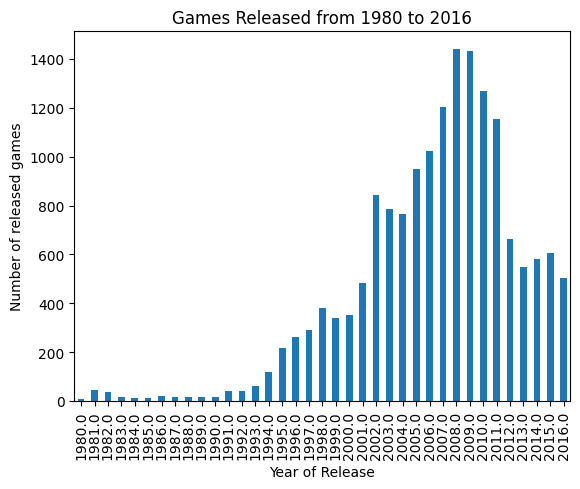

In [6]:
games_by_year = data.groupby('year_of_release')['name'].count().reset_index().rename(columns={'name':'count'})
#display(games_by_year.head())
plt.figure(1, figsize=(15,5))
games_by_year.plot(kind='bar', x='year_of_release', y='count', 
                   xlabel='Year of Release', ylabel='Number of released games',
                  title= 'Games Released from 1980 to 2016', legend=None)
plt.show()

It can be seen that the difference in games released is quite different in each year, with 2008 and 2009 being the years where the most video games were launched.
Also, before 1995 the number of games launched were less than 200

#### 3.2 How do sales differ between various platforms?

platform,DS,PS2,PS3,Wii,X360
year_of_release,,,,,
1985.0,0.02,NaN,NaN,NaN,NaN
2000.0,NaN,39.17,NaN,NaN,NaN
2001.0,NaN,166.43,NaN,NaN,NaN
2002.0,NaN,207.14,NaN,NaN,NaN
2003.0,NaN,185.93,NaN,NaN,NaN
2004.0,17.27,221.50,NaN,NaN,NaN
2005.0,130.14,160.98,0.19,NaN,9.22
2006.0,119.81,107.28,21.44,140.19,51.79
2007.0,147.23,76.10,73.19,153.41,95.42


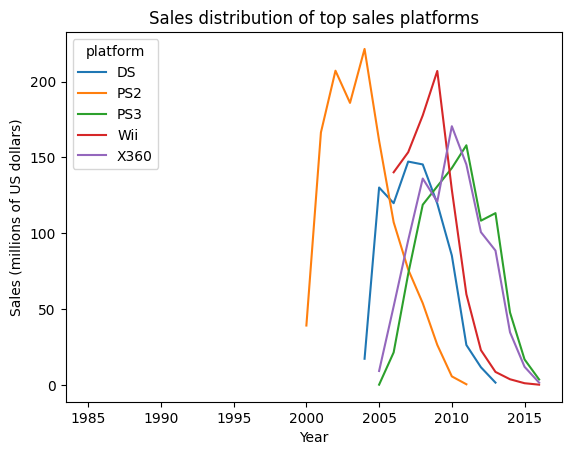

In [12]:
# Se obtienen las plataformas con mayores ventas.
platform_total_sales = data.pivot_table(index='platform',
                                  values= 'total_sales',
                                  aggfunc= 'sum').sort_values('total_sales', ascending=False)
#display(platform_total_sales.head()) 
top_platforms = ['PS2', 'X360', 'PS3', 'Wii','DS']

# Se obtiene la distribución de ventas de las plataformas top
top_platforms_total_sales = data[data['platform'].isin(top_platforms)]
top_platforms_total_sales_distr = top_platforms_total_sales.pivot_table(index= 'year_of_release',
                                                            columns= 'platform',
                                                            values= 'total_sales',
                                                            aggfunc='sum')
#display(top_platforms_sales_distr)

# Se construyen los gráficos de distribución de ventas
top_platforms_total_sales_distr.plot(kind='line', title= 'Sales distribution of top sales platforms',
                               xlabel = 'Year', ylabel= 'Sales (millions of US dollars)', 
                               grid=False, linewidth=1.5)
display(top_platforms_total_sales_distr.head(10))
plt.show()

<div style="background-color: #cce5ff; padding: 10px;">
    <22DUDA PARA EL REVISOR:l</22
    >
    <En la gráfica anterior, los datos de la plataforma DS, tienen un valor de 0.02 en el año 1985, sin embargo, este punto no se muestra en la grafica. La verdad no comprendo porque pasa esto, o que puedo estar haciendo mal a momento de usar el método plot(). Espero me puedan apoyar.
    l.</p>
</div>


For the platforms with the highest sales, it is true that:
- Top sales platforms start to have sales from 2000 with PS2- Their  sales increase drastically as soon as the platform is launched on the market.
- The average popularity of these platforms is 5 years, except for PS3 and X360, whose life cycle is approximately 10 years.
- After that time, platform sales tend to fall drastily.ly.

#### 3.3 Data is limited and leading sales platforms are analyzed

With the information in points 2.1 and 2.2, it was decided to use the data from 1995 onwards, since this year is where the video game releases per year are significant and where it is found the platforms with the highest video game sales. So, form now on 'new_data' df will be use instead of data: 

In [13]:
new_data = data[data['year_of_release']>=1995]
#display(new_data.head())

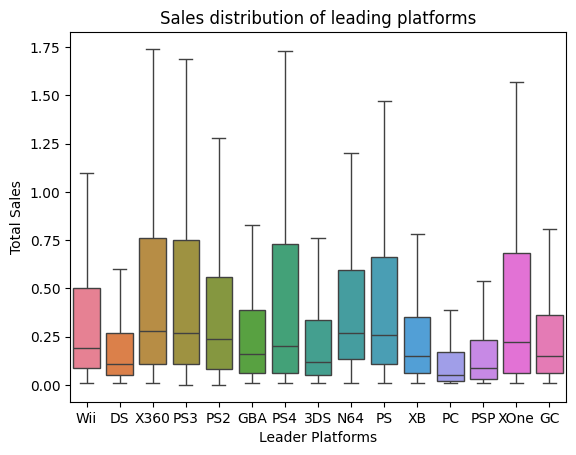

       total_sales
count    15.000000
mean      0.529631
std       0.192250
min       0.244032
25%       0.368917
50%       0.583451
75%       0.690682
max       0.801378
(15133, 12)


In [15]:
# Se obtienen las plataformas líderes en ventas: 
  # Consideramos plataformas lideres en ventas a aquellas que superen los 100 mill. USD
platform_total_sales = new_data.pivot_table(index='platform',
                                  values= 'total_sales',
                                  aggfunc= 'sum').sort_values('total_sales', ascending=False)

leader_platforms = list(platform_total_sales[platform_total_sales['total_sales']>=150].index)

leaders_data = new_data[new_data['platform'].isin(leader_platforms)]
#display(leaders_data)
#Se grafica las distribución de las ventas de las plataformas líderes usando un boxplot:
 # En el gráfico se excluyeron los valores atípicos
sns.boxplot(x= 'platform', y= 'total_sales', data= leaders_data, showfliers= False, hue='platform')
plt.title('Sales distribution of leading platforms')
plt.xlabel('Leader Platforms')
plt.ylabel('Total Sales')
plt.show()

# Se analízan los promedios de ventas de las plataformas líderes:
leaders_mean_sales = leaders_data.pivot_table(index='platform', values='total_sales', aggfunc= 'mean')
#display(leaders_mean_sales)
print(leaders_mean_sales.describe())
print(leaders_data.shape)

It is observed that the sales distributions for the most popular platforms are quite different between them. It is important to note that in the boxplot, the outliers of each distribution are not shown. However, the average total sales average is approximately 0.5. and the descriptive statistics tell us that the standard deviation is relatively small, 0.19, so that all the most popular platforms tend to average sales close to this value.

#### 3.4 Case Study: Rating analysis for the X360 Platform

Next, an analysis will be done for the columns *'critic_score'* and *'user_score'* to analyze how user and professional reviews affect the sales of a specific platform, the X360 platform will be used as example.

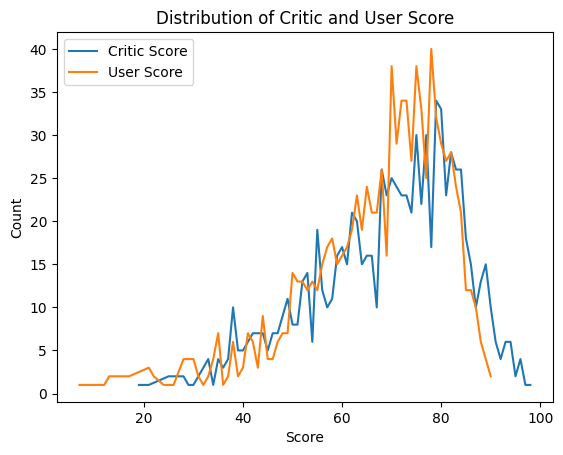

In [17]:
# Gráfico de dispersión para 'critic_score' y 'user_score'
x360_data = new_data[new_data['platform']=='X360']
#display(x360_data.head())

disp_critic_score = x360_data.pivot_table(index= 'critic_score',
                                          values= 'name',
                                          aggfunc='count').reset_index().rename(columns= {'name':'count'})
#display(disp_critic_score)

disp_user_score = x360_data.pivot_table(index= 'user_score',
                                          values= 'name',
                                          aggfunc='count').reset_index().rename(columns= {'name':'count'})
disp_user_score['user_score'] = disp_user_score['user_score'] * 10 # Normalizamos el user_score a 100 para compararlo con critic_score
#display(disp_user_score)
plt.plot(disp_critic_score['critic_score'],disp_critic_score['count'], label = 'Critic Score')
plt.plot(disp_user_score['user_score'], disp_user_score['count'], label = 'User Score')
plt.title('Distribution of Critic and User Score')
plt.xlabel('Score')
plt.ylabel('Count')
plt.legend()
plt.show()

In [18]:
# Cálculo de la correlación entre critic_Score y las ventas:
corr_critics_sales = x360_data['critic_score'].corr(x360_data['total_sales'])
print('Correlation critic score - Sales: ',corr_critics_sales)

# Cálculo de la correlación entre user_Score y las ventas:
corr_users_sales = x360_data['user_score'].corr(x360_data['total_sales'])
print('Correlation users score - Sales: ',corr_users_sales)

Correlation critic score - Sales:  0.3920215623908319
Correlation users score - Sales:  0.11328290875682315


It is noted that the distribution of user and critic scores is very similar, with user scores slightly lower than those of critics. 
Both user and critic opinions show a positive correlation with game sales; however, critic reviews have a greater influence on sales. This may be an important factor to consider when creating a sales strategy for the future.

Now, lets compare the sales of video games of X360 on other top platforms:

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,total_sales
14,Kinect Adventures!,X360,2010.0,Misc,15.00,4.89,0.24,1.69,61.0,6.3,E,21.82
16,Grand Theft Auto V,PS3,2013.0,Action,7.02,9.09,0.98,3.96,97.0,8.2,M,21.05
17,Grand Theft Auto: San Andreas,PS2,2004.0,Action,9.43,0.40,0.41,10.57,95.0,9.0,M,20.81
23,Grand Theft Auto V,X360,2013.0,Action,9.66,5.14,0.06,1.41,97.0,8.1,M,16.27
29,Call of Duty: Modern Warfare 3,X360,2011.0,Shooter,9.04,4.24,0.13,1.32,88.0,3.4,M,14.73


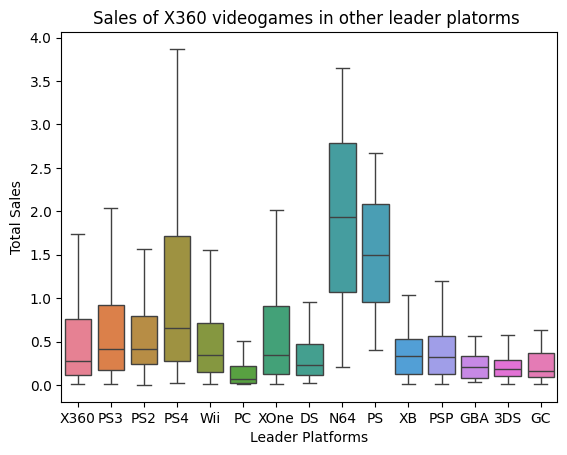

In [28]:
# Obtenemos los juegos de X360:
x360_games = x360_data['name']
x360_games_in_leaders = leaders_data[leaders_data['name'].isin(x360_games)]
display(x360_games_in_leaders.head())
# creamos el gráfico de ventas de videojuegos de X360 en otras plataformas (excluimo valores atípicos):
sns.boxplot(x= 'platform', y= 'total_sales', data= x360_games_in_leaders, showfliers= False, hue='platform')
plt.title('Sales of X360 videogames in other leader platorms ')
plt.xlabel('Leader Platforms')
plt.ylabel('Total Sales')
plt.show()

We note that X360 shares some games with other platforms. When comparing with these other platforms, the distribution of X360 sales is very similar, except for the N64 and PS platforms, where game sales are evidently higher on these platforms than on X360.

#### 3.5 General distribution of game sales by genre

In [33]:
new_data.head()
new_data['genre'].unique().shape

(12,)

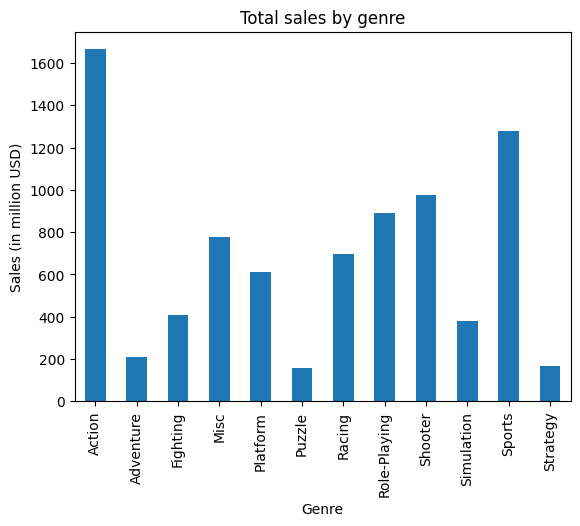

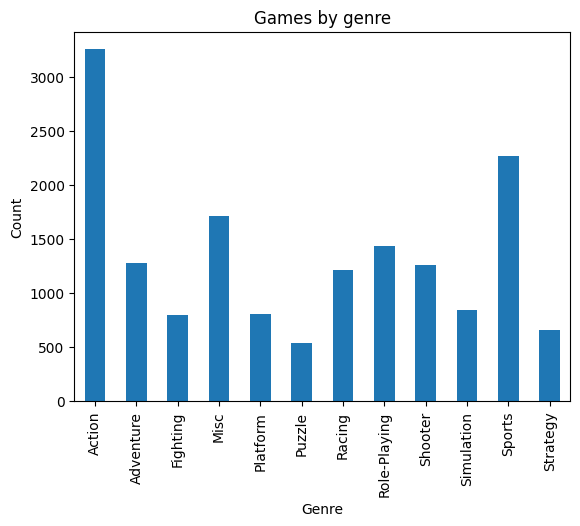

Correlation between sales by genre and the number of games per genre: 0.9035489639798641


In [57]:
sales_by_genre = new_data.pivot_table(index= 'genre',
                                      values= 'total_sales',
                                      aggfunc= 'sum').reset_index()
games_by_genre = new_data.pivot_table(index= 'genre',
                                      values= 'name',
                                      aggfunc= 'count').reset_index()

sales_by_genre.plot(kind='bar', x='genre', title='Total sales by genre', xlabel='Genre', ylabel='Sales (in million USD)',
                   legend=None)
games_by_genre.plot(kind='bar', x='genre', title='Games by genre', xlabel='Genre', ylabel='Count', legend=None)
plt.show()

# Cálculo de la correlación entre las ventas por genero y el numero de juegos por genero:
corr_sales_games = sales_by_genre['total_sales'].corr(games_by_genre['name'])
print(f'Correlation between sales by genre and the number of games per genre: {corr_sales_games}')

With the 'Sales by Genre' chart, we can see that action and sports video games are the best-selling. However, with the 'Games by Genre' chart, we observe that in the dataset, these categories also have the highest number of games. Therefore, when calculating the correlation, we obtain a strong positive correlation, suggesting that these categories are much more profitable, perhaps due to the fact that there is a greater variety of games in these categories.

## 4. Users Profiles by Region
#### 4.1 Top 5 main platforms:

#### 4.2 Top 5 main genres:

#### 4.3 ESRB rating: